In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import detrend
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, brier_score_loss, log_loss
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import tree

sys.path.append('/scistor/ivm/jsn295/Weave')
from Weave.models import fit_predict_evaluate, fit_predict, hyperparam_evaluation, crossvalidate, evaluate
from Weave.utils import brier_score_clim, reliability_plot

Perhaps also the exceedance properties in y. Balance over the whole timeline? What does detrending do?

In [3]:
Y_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/response.multiagg.trended.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),slice(None),slice(None))]
y_det = y_det = pd.DataFrame(detrend(y, axis = 0), index = y.index, columns = y.columns)

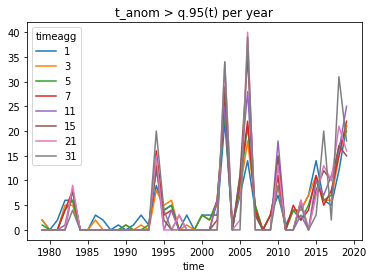

In [61]:
exceed = y > y.quantile(0.95, axis = 0)
exceed.columns = exceed.columns.droplevel([0,-1])
exceed.groupby(y.index.year).sum().plot(title = 't_anom > q.95(t) per year')

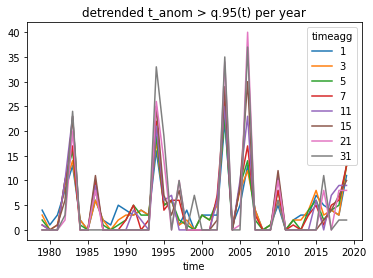

In [62]:
exceed_det = y_det > y_det.quantile(0.95, axis = 0)
exceed_det.columns = exceed_det.columns.droplevel([0,-1])
exceed_det.groupby(y.index.year).sum().plot(title = 'detrended t_anom > q.95(t) per year')

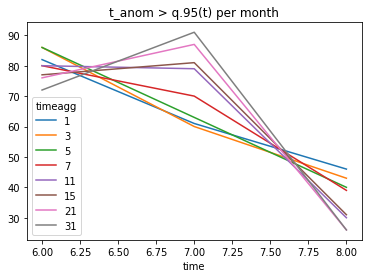

In [64]:
exceed.groupby(y.index.month).sum().plot(title = 't_anom > q.95(t) per month')

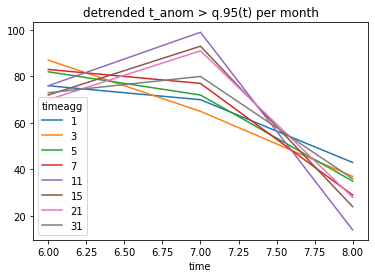

In [65]:
exceed_det.groupby(y.index.month).sum().plot(title = 'detrended t_anom > q.95(t) per month')

These exceedence plots are quite striking. We are combining the different response timescales and defining an anomalie relative to the climatological mean. (More exceedence counts in june does not mean that it is absolutely hotter in june). Also trended and de-trended data agree on the patterns. Big heatwaves clearly in there. Daily exceedence are more distributed. Longer exceedences really related to the. Interesting is also the seasonal pattern. Shorter (relative) extremes more often in june. Longer (relative) extremes more often in july.

This is an artefact of the left stamping!

## Checking a tree classifier structure

In [6]:
Y_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),3,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),0,slice(None),'spatcov')].dropna(axis = 0, how = 'any')
y = y.reindex(X.index)
#y = pd.Series(detrend(y), index = y.index, name = y.name) # Also here you see that detrending improves Random forest performance a bit
y = y > y.quantile(0.90)

classif = RandomForestClassifier(n_estimators = 1000, min_impurity_decrease=0.05)
test = fit_predict_evaluate(classif, X, y, n_folds = 10, properties_too = True, balance_training = 'undersample', evaluate_kwds = dict(scores = [brier_score_loss,log_loss], score_names = ['bs','ll']))

manipulating args (RandomForestClassifier(min_impurity_decrease=0.05, n_estimators=1000),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(min_impurity_decrease=0.05, n_estimators=1000),)
training set has been balanced with undersample from 3229 to 340
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(min_impurity_decrease=0.05, n_estimators=1000),)
training set has been balanced with undersample from 3229 to 356
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(min_impurity_decrease=0.05, n_estimators=1000),)
training set has been balanced with undersample from 3229 to 358
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(min_impurity_decrease=0.05, n_estimators=1000),)
training set has been balanced with undersample from 3229 to 324
fold 4, kwargs: dict_keys(['X_train', 'y_train', 'X_val',

In [3]:
test.groupby('score').mean()

score
bs              0.181275
ll              0.550077
bs_val/train    1.026995
ll_val/train    1.016767
max_depth       0.954000
node_count      2.916667
n_leaves        1.958333
dtype: float64

In [164]:
brier_score_clim(0.1)

0.09000000000000002

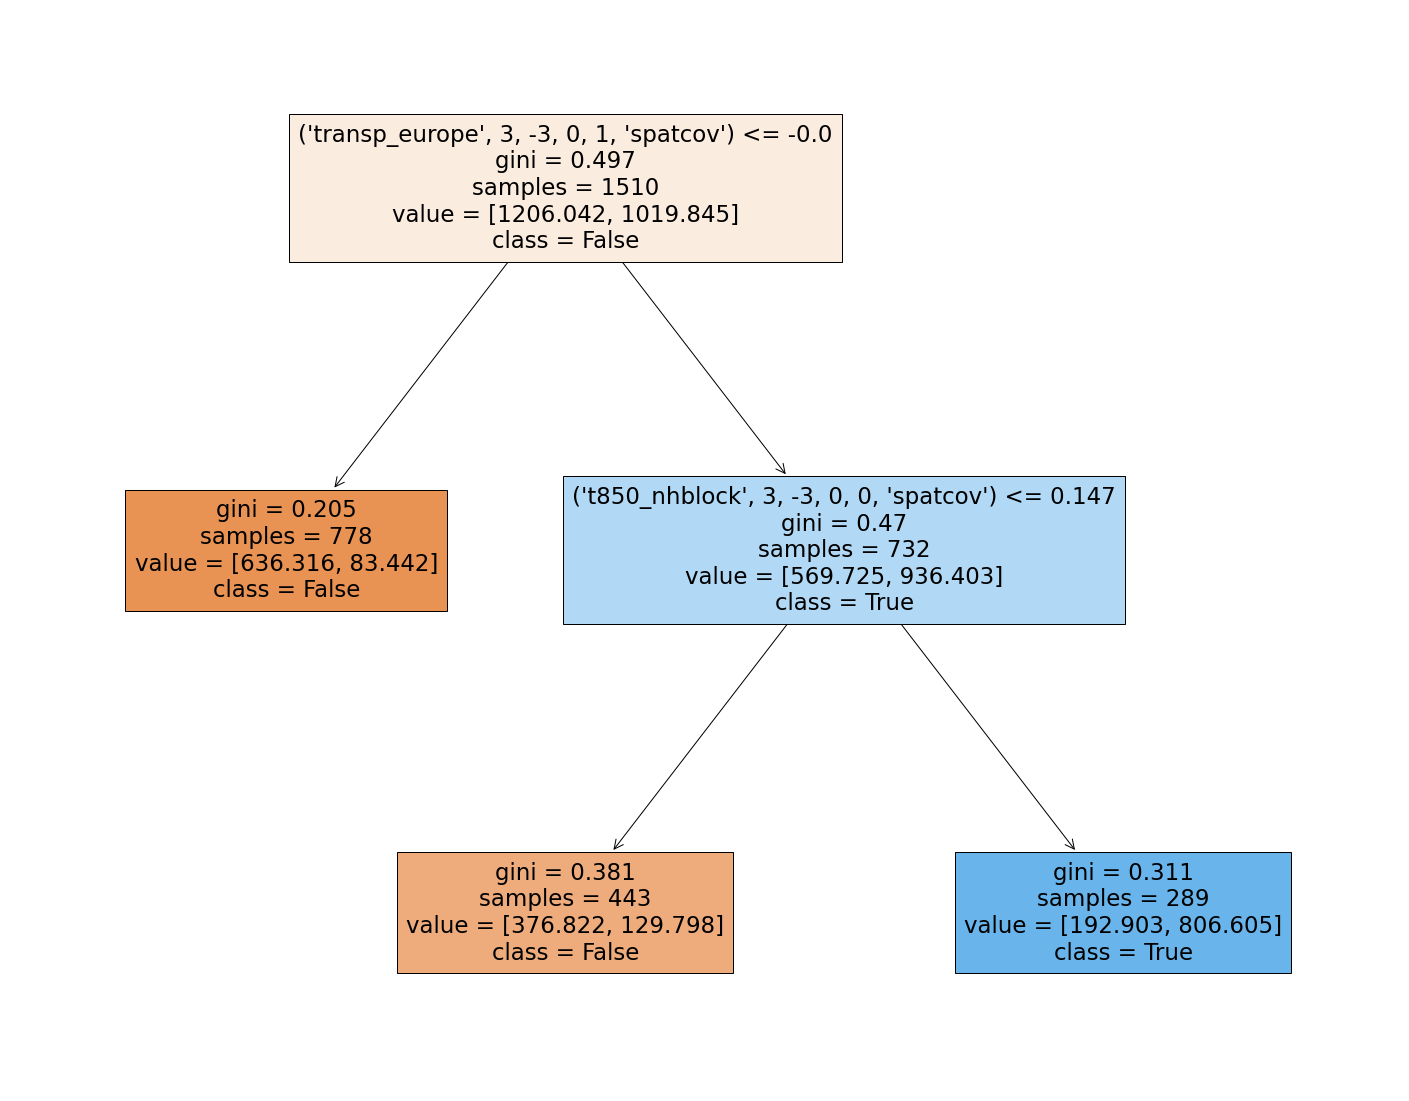

In [110]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classif.estimators_[3], feature_names=X.columns, class_names= [str(b) for b in classif.classes_], filled = True)

Cool, when you choose a short separation and short timescale. Usually it is an atmospheric variable like z300_nhnorm / t850 / tcc as the top variable. Color is corresponding to the label. Split to left means 'yes', split to right means 'no'

Not detrending before >q0.95 labeling and 3-fold cross validation, leads to worst scores in the last fold. Does that correspond to my intuition of bad performance when training on first 2/3 (with little counts) and evaluation on last 1/3 (with more counts, and perhaps different heatwave physics)?

## Hyper parameters for the classifiers

In [17]:
# A wrapper because for validation folds with only non-exceedences the regular function throws an error, and requires both labels
def log_loss_wrapper(*args,**kwargs):
    return log_loss(*args, **kwargs, labels = [False,True])

In [8]:
Y_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),15,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),-15,slice(None),'spatcov')].dropna(axis = 0, how = 'any')
y = y.reindex(X.index)
y = pd.Series(detrend(y), index = y.index, name = y.name) # Also here you see that detrending improves Random forest performance a bit
y = y > y.quantile(0.9)

hyperparams = dict(min_samples_split = [20,30], max_depth = [5,10,15])
fixed_params = dict(n_estimators = 750, n_jobs = 20, max_features = 0.2)

ret = hyperparam_evaluation(RandomForestClassifier, X, y, hyperparams, fixed_params, fit_predict_kwds = dict(n_folds = 10, balance_training = None, properties_too = True, evaluate_kwds = dict(scores = [brier_score_loss,log_loss_wrapper], score_names = ['bs','ll'])))
ret_under = hyperparam_evaluation(RandomForestClassifier, X, y, hyperparams, fixed_params, fit_predict_kwds = dict(n_folds = 10, balance_training = 'undersample', properties_too = True, evaluate_kwds = dict(scores = [brier_score_loss,log_loss_wrapper], score_names = ['bs','ll'])))
ret_over = hyperparam_evaluation(RandomForestClassifier, X, y, hyperparams, fixed_params, fit_predict_kwds = dict(n_folds = 10, balance_training = 'oversample', properties_too = True, evaluate_kwds = dict(scores = [brier_score_loss,log_loss_wrapper], score_names = ['bs','ll'])))

manipulating args (RandomForestClassifier(max_depth=5, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
fold 4, kwargs: dict_keys([

fold 7, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
fold 8, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
fold 9, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
manipulating args (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
fold 1, kwargs: dict_keys

fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with undersample from 3229 to 690
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with undersample from 3229 to 694
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with undersample from 3229 to 580
fold 4, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=20,
                       n_estima

fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with undersample from 3229 to 690
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with undersample from 3229 to 694
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with undersample from 3229 to 580
fold 4, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estima

fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5768
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5764
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=20,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5878
fold 4, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=20,
                       n_estima

fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5768
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5764
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estimators=750, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5878
fold 4, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_split=30,
                       n_estima

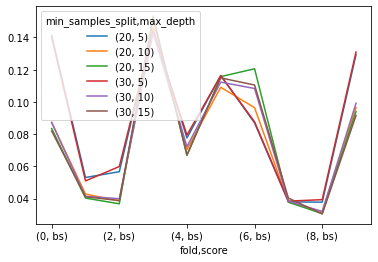

In [19]:
ret_over.loc[(slice(None),'bs'),:].plot()

In [11]:
ret.groupby('score').mean()

min_samples_split         20                               30             \
max_depth                 5          10         15         5          10   
score                                                                      
bs                  0.075804   0.076248   0.076967   0.076080   0.077081   
ll                  0.267167   0.272253   0.273732   0.268997   0.274948   
bs_val/train        3.120425   8.590700  11.835146   2.929134   6.555510   
ll_val/train        2.612292   5.907266   7.288920   2.510702   4.814341   
max_depth           5.000000   9.991333  13.687600   5.000000   9.987067   
node_count         35.000533  76.105600  90.239733  32.649867  68.854933   
n_leaves           18.000267  38.552800  45.619867  16.824933  34.927467   

min_samples_split             
max_depth                 15  
score                         
bs                  0.077073  
ll                  0.276045  
bs_val/train        8.258918  
ll_val/train        5.631635  
max_depth          13.555333  
node_count         82.119467  
n_leaves           41.559733

In [12]:
ret_under.groupby('score').mean()

min_samples_split         20                               30             \
max_depth                 5          10         15         5          10   
score                                                                      
bs                  0.109005   0.096454   0.098010   0.113037   0.098937   
ll                  0.368260   0.335876   0.338525   0.378178   0.344443   
bs_val/train        3.320962   5.143702   5.699481   2.784720   3.761553   
ll_val/train        2.304339   3.106163   3.281889   2.038410   2.494094   
max_depth           5.000000   9.380533  10.452000   5.000000   9.349467   
node_count         31.064267  47.958667  49.797333  27.502667  42.116800   
n_leaves           16.032133  24.479333  25.398667  14.251333  21.558400   

min_samples_split             
max_depth                 15  
score                         
bs                  0.101195  
ll                  0.352144  
bs_val/train        4.083494  
ll_val/train        2.654083  
max_depth          10.366133  
node_count         44.525600  
n_leaves           22.762800

In [13]:
ret_over.groupby('score').mean()

min_samples_split         20                                30             \
max_depth                 5          10          15         5          10   
score                                                                       
bs                  0.088204   0.075708    0.077917   0.088684   0.077392   
ll                  0.306806   0.264097    0.268498   0.308808   0.270216   
bs_val/train        3.223435  14.750085   34.929825   3.224126  14.045309   
ll_val/train        2.215970   7.839100   15.111026   2.217996   7.277443   
max_depth           5.000000  10.000000   14.976533   5.000000  10.000000   
node_count         42.412800  88.907733  104.680267  41.829333  85.668533   
n_leaves           21.706400  44.953867   52.840133  21.414667  43.334267   

min_samples_split              
max_depth                  15  
score                          
bs                   0.076856  
ll                   0.266488  
bs_val/train        30.873259  
ll_val/train        12.795950  
max_depth           14.970267  
node_count         101.425333  
n_leaves            51.212667

### Lets first optimize without balancing.

In [36]:
hyperparams = dict(max_features = [0.1,0.15]) # [0.1,0.15,0.2,0.25,0.3,0.35]
fixed_params = dict(n_estimators = 1000, n_jobs = 20, min_samples_split = 20, max_depth = 6)

ret = hyperparam_evaluation(RandomForestClassifier, X, y, hyperparams, fixed_params, fit_predict_evaluate_kwds = dict(n_folds = 10, balance_training = None, properties_too = True, evaluate_kwds = dict(scores = [brier_score_loss,log_loss_wrapper], score_names = ['bs','ll'])))

manipulating args (RandomForestClassifier(max_depth=6, max_features=0.1, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.1, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.1, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.1, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.1, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 4, kwargs: dict_k

fold 7, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.25, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 8, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.25, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 9, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.25, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
manipulating args (RandomForestClassifier(max_depth=6, max_features=0.3, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.3, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: dic

In [37]:
ret.groupby('score').mean()

max_features,0.10,0.15,0.20,0.25,0.30,0.35
score,,,,,,
bs,0.076444,0.075476,0.075831,0.076254,0.075959,0.076136
ll,0.269091,0.266325,0.268180,0.270472,0.268629,0.269787
bs_val/train,3.718104,3.995393,4.159672,4.286594,4.316992,4.386090
ll_val/train,3.014175,3.179113,3.295853,3.393361,3.404481,3.459442
max_depth,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
node_count,49.386600,47.087600,45.948200,44.872400,44.301200,43.757400
n_leaves,25.193300,24.043800,23.474100,22.936200,22.650600,22.378700


### Now optimizing with oversampling

In [38]:
hyperparams = dict(min_samples_split = [20,40,60], max_depth = [6,10])
fixed_params = dict(n_estimators = 1000, n_jobs = 20, max_features = 0.15)

ret = hyperparam_evaluation(RandomForestClassifier, X, y, hyperparams, fixed_params, fit_predict_kwds = dict(n_folds = 10, balance_training = 'oversample', properties_too = True, evaluate_kwds = dict(scores = [brier_score_loss,log_loss_wrapper], score_names = ['bs','ll'])))

manipulating args (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5830
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5768
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5764
fold 3, kwargs: dict_keys(['X_

fold 9, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=40,
                       n_estimators=1000, n_jobs=20),)
training set has been balanced with oversample from 3230 to 5834
manipulating args (RandomForestClassifier(max_depth=10, max_features=0.15, min_samples_split=40,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.15, min_samples_split=40,
                       n_estimators=1000, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5830
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.15, min_samples_split=40,
                       n_estimators=1000, n_jobs=20),)
training set has been balanced with oversample from 3229 to 5768
fold 2, kwargs: dict_keys([

fold 8, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.15, min_samples_split=60,
                       n_estimators=1000, n_jobs=20),)
training set has been balanced with oversample from 3230 to 5766
fold 9, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=10, max_features=0.15, min_samples_split=60,
                       n_estimators=1000, n_jobs=20),)
training set has been balanced with oversample from 3230 to 5834


In [39]:
ret.groupby('score').mean()

min_samples_split         20                    40                    60  \
max_depth                 6          10         6          10         6    
score                                                                      
bs                  0.081762   0.075014   0.081844   0.076148   0.083333   
ll                  0.287595   0.262685   0.288863   0.266514   0.293401   
bs_val/train        4.657099  15.099785   4.378736  12.396916   4.130827   
ll_val/train        2.889883   7.719663   2.771745   6.276898   2.666766   
max_depth           6.000000  10.000000   6.000000  10.000000   6.000000   
node_count         58.231800  92.872200  54.795200  85.730600  51.959000   
n_leaves           29.615900  46.936100  27.897600  43.365300  26.479500   

min_samples_split             
max_depth                 10  
score                         
bs                  0.075470  
ll                  0.266741  
bs_val/train       10.010894  
ll_val/train        5.198977  
max_depth           9.999900  
node_count         80.401000  
n_leaves           40.700500

### small test, is there skill with a gap of 1 month?

In [33]:
Y_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),15,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),-31,slice(None),'spatcov')].dropna(axis = 0, how = 'any')
y = y.reindex(X.index)
y = pd.Series(detrend(y), index = y.index, name = y.name) # Also here you see that detrending improves Random forest performance a bit
y = y > y.quantile(0.9)

model = RandomForestClassifier(n_estimators = 1000, n_jobs = 20, min_samples_split = 20, max_depth = 6, max_features = 0.15)
test = fit_predict(model, X, y, balance_training = None)
#test = fit_predict_evaluate(model, X, y, balance_training=None, evaluate_kwds = dict(scores = [brier_score_loss,log_loss_wrapper], score_names = ['bs','ll']))

manipulating args (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 4, kwargs: d

So this is the approach that Maurice recommended. First fit_predict only over all the cv folds. And then later evaluating with a score

In [34]:
test.index = test.index.droplevel(0)

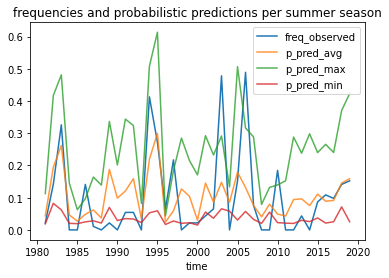

In [35]:
# predictions for validation folds vs truth.
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
y.groupby(y.index.year).mean().plot(ax = ax, label = 'freq_observed')
test.groupby(test.index.year).mean().plot(ax = ax, label = 'p_pred_avg', alpha = 0.8)
test.groupby(test.index.year).max().plot(ax = ax, label = 'p_pred_max', alpha = 0.8)
test.groupby(test.index.year).min().plot(ax = ax, label = 'p_pred_min', alpha = 0.8)
ax.legend()
ax.set_title('frequencies and probabilistic predictions per summer season')
plt.show()

In [36]:
scores = evaluate(y_true= y, y_pred= test, scores = [brier_score_loss, log_loss], score_names = ['bs','ll'])
print(scores)

score
bs    0.078892
ll    0.280674
dtype: float64


In [37]:
print(f"bss is:{1 - scores.loc['bs'] / brier_score_clim(0.1)}")

bss is:0.12341732645499759


Text(0, 0.5, 'count')

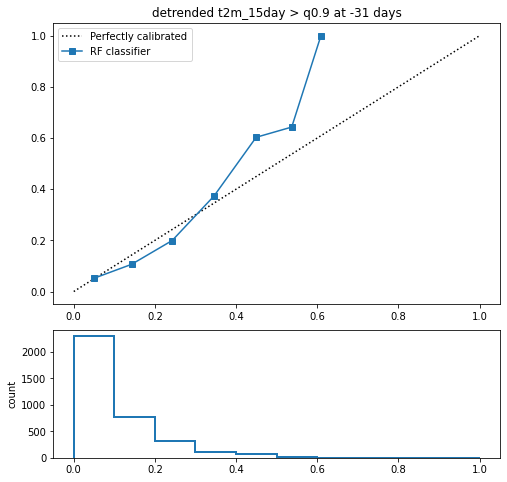

In [52]:
from sklearn.calibration import calibration_curve # Wrap this into a utility function!
bins = 10
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
fig.patch.set_facecolor('white')
fraction_of_positives, mean_predicted_value = calibration_curve(y_true = y, y_prob = test, n_bins = bins)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(mean_predicted_value,fraction_of_positives, 's-',label = "RF classifier")
ax1.legend()
ax1.set_title('detrended t2m_15day > q0.9 at -31 days')
ax2.hist(test, range=(0, 1), bins=bins, label = "RF classifier", histtype="step", lw=2)
ax2.set_ylabel('count')

The reverse approach (of computing a bs per fold) also leads to positive skill.

In [27]:
test = fit_predict_evaluate(model, X, y, balance_training=None, evaluate_kwds = dict(scores = [brier_score_loss,log_loss_wrapper], score_names = ['bs','ll']))
test.groupby('score').mean()

manipulating args (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 4, kwargs: d

score
bs              0.079036
ll              0.281051
bs_val/train    3.482333
ll_val/train    2.945544
dtype: float64

So there seem to be some skill here at this separation gap. (bs is less than the climatological one). But with the reverse approach there exists variability in the scores over the different folds (therefore a case of varying climatology). Can I correct this, by cross-validating the response?

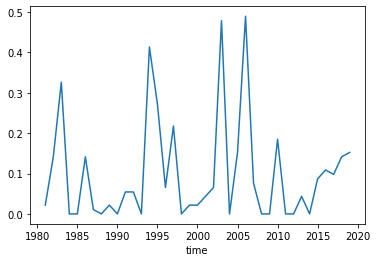

In [162]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
y.groupby(y.index.year).mean().plot(ax = ax)

In [145]:
@crossvalidate(n_folds=10) # Crossvalidate decorator changes the arguments to X_in, y_in
def extract_probs_and_bs(y_train = None, y_val = None, where = 'val', **kwargs) -> pd.Series:
    """
    Extracting positive probabilities for a certain validation fold
    if where = 'val', else 'train'
    """
    if where == 'val':
        y = y_val
    elif where == 'train':
        y = y_train
    else:
        raise ValueError("where should be one of ['val','train']")
    p = y.sum() / len(y)
    bs = brier_score_clim(p)
    mid_timestamp = y_val.index[len(y_val)//2] # Always from the validation fold, because that is where the non-reference scores are computed
    return pd.Series([p, bs], index = pd.MultiIndex.from_product([[mid_timestamp], ['p','bs_clim']], names = ['midpoint','score']))


In [146]:
clims_val = extract_probs_and_bs(X_in = X, y_in = y, where = 'val')
clims_train = extract_probs_and_bs(X_in = X, y_in = y, where = 'train')

manipulating kwargs {'where': 'val'}
fold 0, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
fold 1, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
fold 2, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
fold 3, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
fold 4, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
fold 5, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
fold 6, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
fold 7, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
fold 8, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
fold 9, kwargs: dict_keys(['where', 'X_train', 'y_train', 'X_val', 'y_val']), args: ()
manipulating kwargs {'where': 'train'}
fold 0, kwargs: dict_keys(['where', 'X_train', 'y_trai

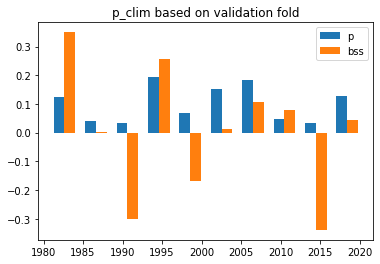

In [158]:
combined = clims_val.unstack(-1).loc[(slice(None),slice(None)),:].join(test.unstack(-1), on = 'fold')
combined['bss'] = 1 - combined['bs']/combined['bs_clim']
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
width = 500
xdiff = pd.Timedelta(500,'days')
ax.bar(x = combined.index.get_level_values('midpoint') - xdiff/2, height=combined['p'], width = width, label = 'p')
ax.bar(x = combined.index.get_level_values('midpoint') + xdiff/2, height=combined['bss'], width = 500, label = 'bss')
ax.legend()
ax.set_title('p_clim based on validation fold')
plt.show()

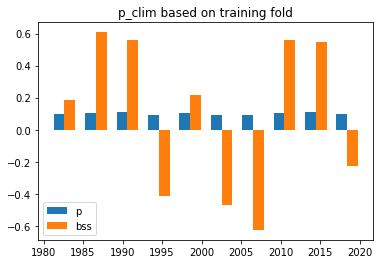

In [159]:
combined = clims_train.unstack(-1).loc[(slice(None),slice(None)),:].join(test.unstack(-1), on = 'fold')
combined['bss'] = 1 - combined['bs']/combined['bs_clim']
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
width = 500
xdiff = pd.Timedelta(500,'days')
ax.bar(x = combined.index.get_level_values('midpoint') - xdiff/2, height=combined['p'], width = width, label = 'p')
ax.bar(x = combined.index.get_level_values('midpoint') + xdiff/2, height=combined['bss'], width = 500, label = 'bss')
ax.legend()
ax.set_title('p_clim based on training fold')
plt.show()

In [156]:
y

time
1981-06-01     True
1981-06-02     True
1981-06-03    False
1981-06-04    False
1981-06-05    False
              ...  
2019-08-27    False
2019-08-28    False
2019-08-29    False
2019-08-30    False
2019-08-31    False
Name: (t2m-mean-anom, 15, 9), Length: 3588, dtype: bool

In [157]:
X

variable   swvl13_europe                               tcc_europe z300_nhnorm  \
timeagg               21                                       21          31   
lag                  -52                                      -52         -62   
separation           -31                                      -31         -31   
clustid                0         1         2         3          0           0   
metric           spatcov   spatcov   spatcov   spatcov    spatcov     spatcov   
time                                                                            
1981-06-01      0.000238  0.000013  0.000022 -0.000159  -0.004812   -7.142684   
1981-06-02      0.000232  0.000013  0.000019 -0.000159  -0.004207   -8.884706   
1981-06-03      0.000226  0.000011  0.000015 -0.000159  -0.003790  -11.081641   
1981-06-04      0.000221  0.000008  0.000012 -0.000159  -0.003320  -12.581796   
1981-06-05      0.000215  0.000005  0.000007 -0.000157  -0.002048  -12.937218   
...                  ...       ...       ...       ...        ...         ...   
2019-08-27      0.000065  0.000027 -0.000061  0.000021   0.001609    5.060339   
2019-08-28      0.000065  0.000029 -0.000062  0.000023   0.001634    3.619464   
2019-08-29      0.000067  0.000030 -0.000065  0.000026   0.001852    2.269707   
2019-08-30      0.000067  0.000031 -0.000067  0.000028   0.001843    1.169876   
2019-08-31      0.000064  0.000031 -0.000069  0.000030   0.001444    0.553343   

variable              sst_nhplus                      ... siconc_nhmin  \
timeagg                       3                   7   ...           31   
lag                          -34                 -38  ...          -62   
separation                   -31                 -31  ...          -31   
clustid             1          0         1         0  ...            0   
metric        spatcov    spatcov   spatcov   spatcov  ...      spatcov   
time                                                  ...                
1981-06-01 -51.380360  -0.016073  0.008320  0.013210  ...    -0.000029   
1981-06-02 -50.065159  -0.013705  0.007547  0.009933  ...    -0.000023   
1981-06-03 -47.861244  -0.012115  0.004799  0.006721  ...    -0.000017   
1981-06-04 -43.161842  -0.010068  0.001712  0.004017  ...    -0.000010   
1981-06-05 -39.365711  -0.007146 -0.000435  0.002273  ...    -0.000004   
...               ...        ...       ...       ...  ...          ...   
2019-08-27  -3.155368   0.006031 -0.001601  0.018859  ...     0.000274   
2019-08-28  -3.228655   0.004469  0.000378  0.017155  ...     0.000304   
2019-08-29  -4.596434   0.001438 -0.001459  0.016517  ...     0.000332   
2019-08-30  -6.064063  -0.001231 -0.004230  0.017753  ...     0.000343   
2019-08-31  -8.173309  -0.002499 -0.008050  0.019464  ...     0.000357   

variable                                 snowc_nhmin                      \
timeagg                     21                    11                       
lag                        -52                   -42                       
separation                 -31                   -31                       
clustid            1         0         1           0         1         2   
metric       spatcov   spatcov   spatcov     spatcov   spatcov   spatcov   
time                                                                       
1981-06-01 -0.000352 -0.000027 -0.000289    0.242579 -0.043718 -0.266172   
1981-06-02 -0.000355 -0.000023 -0.000289    0.134953 -0.048871 -0.279451   
1981-06-03 -0.000363 -0.000020 -0.000287   -0.028832 -0.054974 -0.278712   
1981-06-04 -0.000369 -0.000018 -0.000281   -0.153585 -0.061979 -0.266047   
1981-06-05 -0.000371 -0.000017 -0.000268   -0.215789 -0.069704 -0.240208   
...              ...       ...       ...         ...       ...       ...   
2019-08-27 -0.000233 -0.000005  0.002119   -0.111433 -0.001537  0.110541   
2019-08-28 -0.000154 -0.000006  0.002110   -0.110398 -0.001802  0.111718   
2019-08-29 -0.000087 -0.000027  0.002105   -0.101866 -0.001893  0.11

### Hyperparam evaluation of a classifier at large timescale and lags also with reliability diagrams
No oversampling

In [2]:
Y_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),15,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),-31,slice(None),'spatcov')].dropna(axis = 0, how = 'any')
y = y.reindex(X.index)
y = pd.Series(detrend(y), index = y.index, name = y.name) # Also here you see that detrending improves Random forest performance a bit
y = y > y.quantile(0.9)

In [3]:
hyperparams = dict(min_samples_split = [15,20,25], max_depth = [6,8])
fixed_params = dict(n_estimators = 1000, n_jobs = 20, max_features = 0.15)

ret_full = hyperparam_evaluation(RandomForestClassifier, X, y, hyperparams, fixed_params, fit_predict_kwds = dict(n_folds = 10, balance_training = None))
ret_full.index = ret_full.index.droplevel('fold')

manipulating args (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 4, kwargs: d

fold 7, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 8, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 9, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
manipulating args (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=25,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=25,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: d

NameError: name 'log_loss_wrapper' is not defined

In [6]:
ret_scores = hyperparam_evaluation(RandomForestClassifier, X, y, hyperparams, fixed_params, fit_predict_evaluate_kwds = dict(n_folds = 10, balance_training = None, properties_too = True, evaluate_kwds = dict(scores = [brier_score_loss,log_loss], score_names = ['bs','ll'])))

manipulating args (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 4, kwargs: d

fold 7, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 8, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 9, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
manipulating args (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=25,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=25,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: d

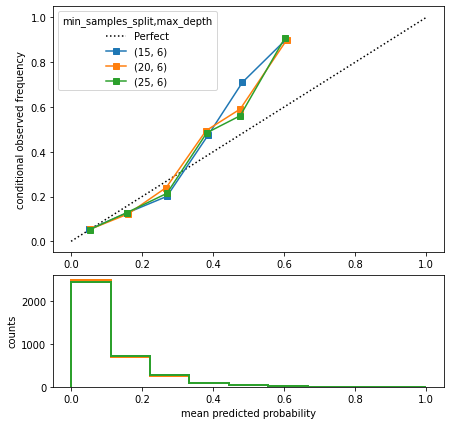

In [22]:
fig, axes = reliability_plot(y_true = y, y_probs = ret_full.loc[:,(slice(None),6)], nbins = 9)

In [14]:
ret_scores.groupby('score').mean()

min_samples_split         15                    20                    25  \
max_depth                  6          8          6          8          6   
score                                                                      
bs                  0.079210   0.079515   0.079094   0.079728   0.078985   
ll                  0.281910   0.282490   0.281244   0.283249   0.280628   
bs_val/train        3.706969   5.865136   3.487608   5.284993   3.332844   
ll_val/train        3.099007   4.460506   2.952931   4.114468   2.847048   
max_depth           6.000000   8.000000   6.000000   8.000000   6.000000   
node_count         47.602600  66.887400  44.998000  62.735600  42.871400   
n_leaves           24.301300  33.943700  22.999000  31.867800  21.935700   

min_samples_split             
max_depth                  8  
score                         
bs                  0.080110  
ll                  0.284528  
bs_val/train        4.850598  
ll_val/train        3.850183  
max_depth           8.000000  
node_count         59.300400  
n_leaves           30.150200

In [21]:
# Especially in the lower end it shows here that depth of 6 is preferred over 8. sample size of 25 seems nice
# Oversampling (requires a bit deeper trees) actually does not improve reliability much. There is a slight change you get more resolution. (> 0.6)

In [27]:
Y_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),5,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),-5,slice(None),'spatcov')].dropna(axis = 0, how = 'any')
y = y.reindex(X.index)
y = pd.Series(detrend(y), index = y.index, name = y.name) # Also here you see that detrending improves Random forest performance a bit
y = y > y.quantile(0.9)
hyperparams = dict(min_samples_split = [15,20,25], max_depth = [6,8,10])
fixed_params = dict(n_estimators = 1000, n_jobs = 20, max_features = 0.15)

ret_full = hyperparam_evaluation(RandomForestClassifier, X, y, hyperparams, fixed_params, fit_predict_kwds = dict(n_folds = 10, balance_training = None))
ret_full.index = ret_full.index.droplevel('fold')

manipulating args (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 4, kwargs: d

fold 7, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 8, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 9, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
manipulating args (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: d

fold 4, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=25,
                       n_estimators=1000, n_jobs=20),)
fold 5, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=25,
                       n_estimators=1000, n_jobs=20),)
fold 6, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=25,
                       n_estimators=1000, n_jobs=20),)
fold 7, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=25,
                       n_estimators=1000, n_jobs=20),)
fold 8, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=8, max_features=0.15, min_samples_split=25,
               

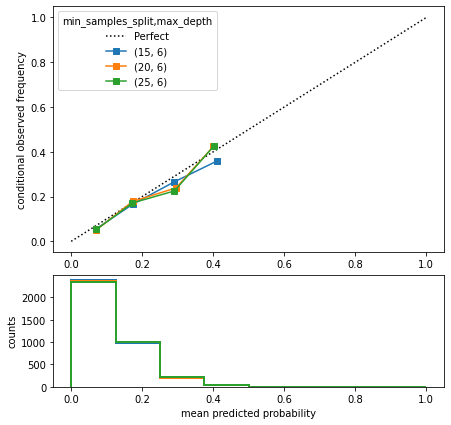

In [35]:
fig, axes = reliability_plot(y_true = y, y_probs = ret_full.loc[:,(slice(None),6)], nbins = 8)

In [39]:
hyperparams = dict(min_samples_split = [15,20], max_depth = [5,6])
fixed_params = dict(n_estimators = 1000, n_jobs = 20, max_features = 0.15)

ret_scores = hyperparam_evaluation(RandomForestClassifier, X, y, hyperparams, fixed_params, fit_predict_evaluate_kwds = dict(n_folds = 10, balance_training = None, properties_too = True, evaluate_kwds = dict(scores = [brier_score_loss,log_loss], score_names = ['bs','ll'])))

manipulating args (RandomForestClassifier(max_depth=5, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 0, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 1, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 2, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 3, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=5, max_features=0.15, min_samples_split=15,
                       n_estimators=1000, n_jobs=20),)
fold 4, kwargs: d

fold 7, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 8, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)
fold 9, kwargs: dict_keys(['X_train', 'y_train', 'X_val', 'y_val']), args: (RandomForestClassifier(max_depth=6, max_features=0.15, min_samples_split=20,
                       n_estimators=1000, n_jobs=20),)


In [42]:
ret_scores.groupby('score').mean()

min_samples_split         15                    20           
max_depth                  5          6          5          6
score                                                        
bs                  0.084209   0.084369   0.084467   0.084431
ll                  0.294548   0.295095   0.295691   0.295620
bs_val/train        1.788332   2.145622   1.763221   2.069708
ll_val/train        1.699739   1.983564   1.683250   1.930830
max_depth           5.000000   6.000000   5.000000   6.000000
node_count         35.900600  49.459000  34.309600  46.583800
n_leaves           18.450300  25.229500  17.654800  23.791900

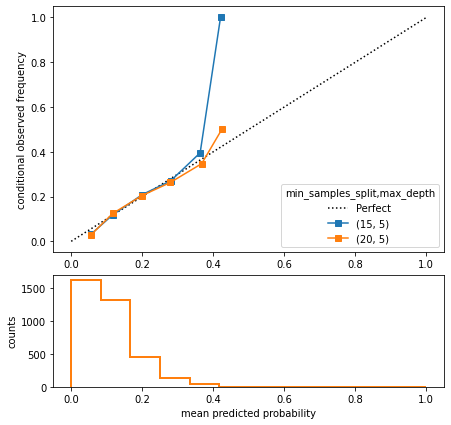

In [46]:
fig, axes = reliability_plot(y_true = y, y_probs = ret_full.loc[:,(slice(None),5)], nbins = 12)